In [427]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from flaml import AutoML
from sklearn.ensemble import HistGradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor

from lightgbm import LGBMRegressor
from prettytable import PrettyTable
import sys  
import os
root_path = os.path.realpath('/..')
sys.path.insert(0, root_path)
%load_ext autoreload
%autoreload 2

from variance_reduction.diff_in_means import DifferenceInMeans
from variance_reduction.cuped import CUPED, multiple_CUPEDs, MultivariateCUPED
from variance_reduction.utils import create_pretty_table, query_snowflake, bootstrap_generator, subsample_generator, bootstrap_data, subsample_data, aaify, add_synthetic_effect, diff_in_means
from variance_reduction.mlrate import MLRATE, AltMLRATE
from variance_reduction.cupac import CUPAC
from variance_reduction.doubly_robust import DoublyRobustEstimator
from variance_reduction.evaluation_pipeline import VREvaluation, VREvaluationAll
from variance_reduction.multivariate_regression import MultivariateRegression, MultivariateRegressionAdjusted


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simple synthetic data

In [366]:
def generate_synthetic_data(n):

    # pre experiment metric
    group_0 = np.random.exponential(10, n//2)
    group_1 = np.random.exponential(10, n//2)

    pre_metric = np.concatenate([group_0, group_1])

    # experiment metric
    ctrl_group_0 = group_0 + np.random.normal(0,1, n//2)
    treatment_group_1 = group_1 + np.random.normal(5,1, n//2) + np.random.normal(0,1, n//2)

    exp_metric = np.concatenate([ctrl_group_0, treatment_group_1])

    # treatment
    treatment = np.concatenate([np.zeros(n//2), np.ones(n//2)])

    # assemble dataframe
    df = pd.DataFrame({
        'exp_metric': exp_metric,
        'treatment': treatment,
        'pre_metric': pre_metric
    })

    # shuffle
    df = df.sample(frac=1).reset_index(drop=True)

    return df


In [367]:
simple_synthetic_df = generate_synthetic_data(10000)

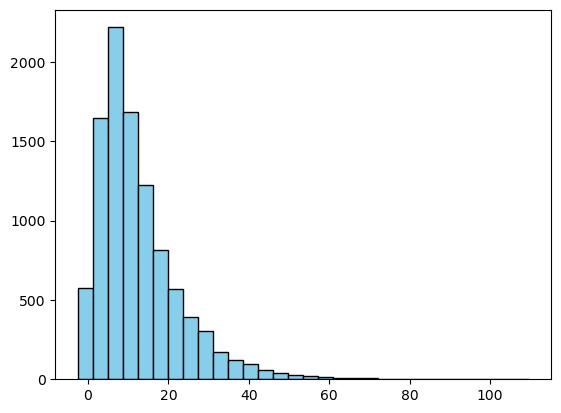

In [368]:
plt.hist(simple_synthetic_df['exp_metric'], bins=30, color='skyblue', edgecolor='black')
plt.show()

## Evaluation on simple synthetic data

In [369]:
method_params_map = {

    'DifferenceInMeans': {
    },
    
    'CUPED': {
        'covariate_column': 'pre_metric'
    },

    'MultivariateRegression': {
        'covariate_columns': ['pre_metric']
    },

    'MultivariateRegressionAdjusted': {
        'covariate_columns': ['pre_metric']
    },

    # 'CUPAC': {
    #     'pre_experiment_data': 'ml_synthetic_df',
    #     'covariate_columns': list(ml_synthetic_df.columns[2:10]),
    #     'model': HistGradientBoostingRegressor,
    #     'model_init_config': {},
    #     'model_fit_config': {}
    # },

    'MLRATE': {
        'K_splits': 2,
        'covariate_columns': ['pre_metric'],
        'model': ElasticNet,
        'model_init_config': {},
        'model_fit_config': {}
    },

    'DoublyRobustEstimator': {
        'covariate_columns': ['pre_metric']
    }

}

In [370]:
evaluator_all = VREvaluationAll([DifferenceInMeans, MultivariateRegression, MultivariateRegressionAdjusted, CUPED, MLRATE, DoublyRobustEstimator])

In [371]:
evaluator_all = evaluator_all.run_all(data=simple_synthetic_df,
                                        treatment_column='treatment',
                                        target_column='exp_metric',
                                        method_params_map=method_params_map,
                                        verbose=True,
                                        n_bootstrap=100,
                                        true_ate=5)
                                  

Running DifferenceInMeans...


100%|██████████| 100/100 [00:02<00:00, 39.55it/s]


Running MultivariateRegression...


100%|██████████| 100/100 [00:02<00:00, 42.73it/s]


Running MultivariateRegressionAdjusted...


100%|██████████| 100/100 [00:02<00:00, 46.23it/s]


Running CUPED...


100%|██████████| 100/100 [00:02<00:00, 48.51it/s]


Running MLRATE...


100%|██████████| 100/100 [00:03<00:00, 30.18it/s]


Running DoublyRobustEstimator...


 58%|█████▊    | 58/100 [00:48<00:38,  1.08it/s]lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
100%|██████████| 100/100 [01:33<00:00,  1.07it/s]

Done!


In [372]:
evaluator_all.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,DifferenceInMeans,5.140795,"(4.769135431383159, 5.488434632717251)",0.140795,"(-0.2308645686168414, 0.48843463271725074)",0.0,"(3.914289379651619e-163, 6.82341392913863e-120)",0.90,0.000000
1,MultivariateRegression,5.005654,"(4.954613064991626, 5.049031342048342)",0.005654,"(-0.04538693500837423, 0.04903134204834185)",0.0,"(0.0, 0.0)",0.95,0.983721
2,MultivariateRegressionAdjusted,5.005641,"(4.954596751282236, 5.049016779625254)",0.005641,"(-0.045403248717764265, 0.049016779625254275)",0.0,"(0.0, 0.0)",0.95,0.983723
3,CUPED,5.004957,"(4.954402238933656, 5.048747462251664)",0.004957,"(-0.045597761066343855, 0.04874746225166433)",0.0,"(0.0, 0.0)",0.95,0.983650
4,MLRATE,5.006615,"(4.9561541636455715, 5.0500915593272335)",0.006615,"(-0.04384583635442809, 0.05009155932723329)",0.0,"(0.0, 0.0)",0.95,0.983738
5,DoublyRobustEstimator,4.996109,"(4.94192307934567, 5.049019047474691)",-0.003891,"(-0.058076920654330434, 0.049019047474691275)",None,None,0.95,0.978827


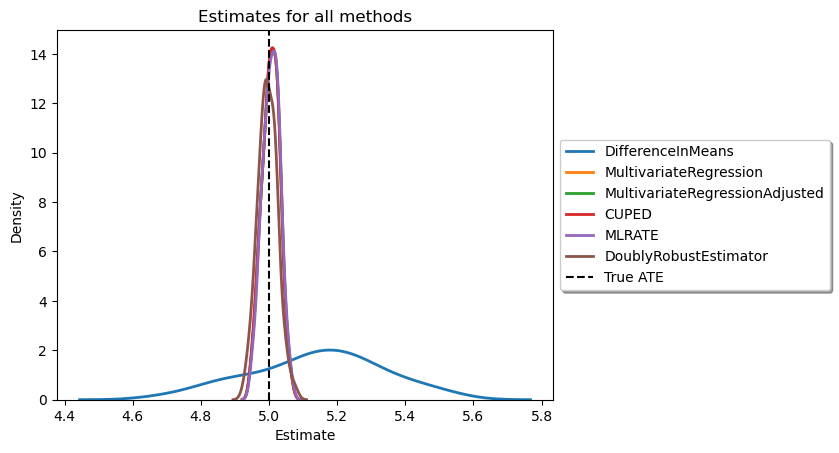

<Axes: title={'center': 'Estimates for all methods'}, xlabel='Estimate', ylabel='Density'>

In [373]:
evaluator_all.plot(plot_what='estimates')

# Granular investigation

## Synthetic data with linear relationship between covariate and target

### Linear methods

In [433]:
simple_synthetic_df = generate_synthetic_data(10000)

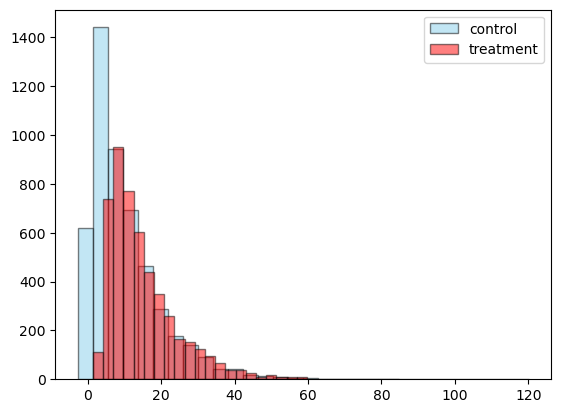

In [432]:
# plot histogram of the experiment metric stratifying by treatment
plt.hist(simple_synthetic_df.loc[simple_synthetic_df.treatment == 0, 'exp_metric'], bins=30, color='skyblue', edgecolor='black', alpha=0.5, label='control')
plt.hist(simple_synthetic_df.loc[simple_synthetic_df.treatment == 1, 'exp_metric'], bins=30, color='red', edgecolor='black', alpha=0.5, label='treatment')
plt.legend()
plt.show()

In [55]:
evaluation_linear_method = VREvaluationAll([DifferenceInMeans,
                                            MultivariateRegression,
                                            MultivariateRegressionAdjusted,
                                            CUPED])

In [56]:
linear_params_map = {
    'DifferenceInMeans': {
    },

    'MultivariateRegression': {
        'covariate_columns': ['pre_metric']
    },

    'MultivariateRegressionAdjusted': {
        'covariate_columns': ['pre_metric']
    },

    'CUPED': {
        'covariate_column': 'pre_metric'
    }
}

In [57]:
evaluation_linear_method = evaluation_linear_method.run_all(data=simple_synthetic_df,
                                                            treatment_column='treatment',
                                                            target_column='exp_metric',
                                                            method_params_map=linear_params_map,
                                                            verbose=True,
                                                            n_bootstrap=100,
                                                            true_ate=5)

Running DifferenceInMeans...


100%|██████████| 100/100 [00:00<00:00, 178.72it/s]


Running MultivariateRegression...


100%|██████████| 100/100 [00:01<00:00, 66.44it/s]


Running MultivariateRegressionAdjusted...


100%|██████████| 100/100 [00:01<00:00, 65.26it/s]


Running CUPED...


100%|██████████| 100/100 [00:01<00:00, 67.90it/s]

Done!


In [58]:
evaluation_linear_method.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,DifferenceInMeans,4.975951,"(4.652298923748792, 5.398654574379944)",-0.024049,"(-0.34770107625120816, 0.3986545743799437)",2.092848e-112,"(4.3442655051625957e-156, 1.8282150669550914e-...",0.96,0.000000
1,MultivariateRegression,5.029659,"(4.980713579326564, 5.071559013051519)",0.029659,"(-0.019286420673435466, 0.07155901305151906)",0.000000e+00,"(0.0, 0.0)",0.77,0.984840
2,MultivariateRegressionAdjusted,5.029659,"(4.980712269831843, 5.071554622460123)",0.029659,"(-0.01928773016815777, 0.0715546224601237)",0.000000e+00,"(0.0, 0.0)",0.77,0.984839
3,CUPED,5.029147,"(4.980093470152741, 5.070663363678767)",0.029147,"(-0.01990652984725878, 0.0706633636787666)",0.000000e+00,"(0.0, 0.0)",0.77,0.984878


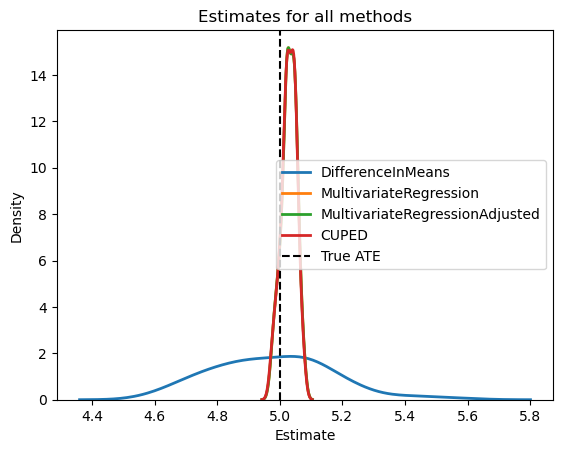

In [59]:
evaluation_linear_method.plot(plot_what='estimates')

In [60]:
bootstrapped_diff_in_means = []
for b_sample in evaluation_linear_method.bootstrap_samples:

    b_data = simple_synthetic_df.iloc[b_sample]
    b_dim = b_data.loc[b_data['treatment'] == 1, 'exp_metric'].mean() - b_data.loc[b_data['treatment'] == 0, 'exp_metric'].mean()

    bootstrapped_diff_in_means.append(b_dim)

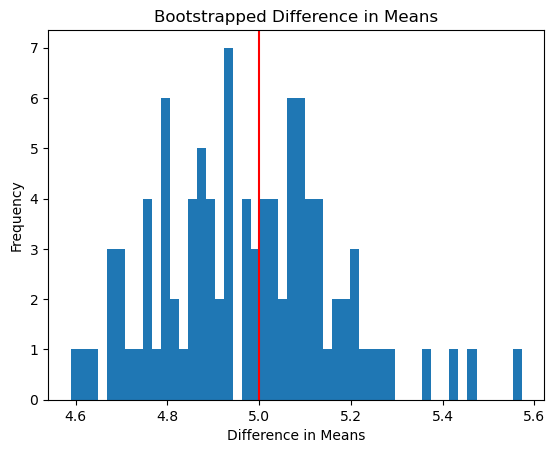

In [61]:
# plot a histogram of bootstrapped_diff_in_means

plt.hist(bootstrapped_diff_in_means, bins=50)
# add a vertical at 5 with label true ATE
plt.axvline(x=5, color='red', label='True ATE')
plt.title('Bootstrapped Difference in Means')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.show()


### CUPAC

In [62]:
pre_exp_simple_synthetic_df = generate_synthetic_data(5000)
pre_exp_simple_synthetic_df = pre_exp_simple_synthetic_df.loc[pre_exp_simple_synthetic_df['treatment'] == 0]

In [63]:
cupac_params_map = {
    'CUPAC': {
        'pre_experiment_data': pre_exp_simple_synthetic_df,
        'covariate_columns': ['pre_metric'],
        'model': ExtraTreesRegressor,
        'model_init_config': {},
        'model_fit_config': {
        }
    }
}


In [64]:
evaluation_cupac = VREvaluation(CUPAC)

In [65]:
evaluation_cupac = evaluation_cupac.run(data=simple_synthetic_df,
                                        treatment_column='treatment',
                                        target_column='exp_metric',
                                        method_params_map=cupac_params_map,
                                        verbose=True,
                                        n_bootstrap=100,
                                        true_ate=5)

Running CUPAC...


100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


In [66]:
evaluation_cupac.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,CUPAC,5.012725,"(4.961170993977567, 5.0710238624601445)",0.012725,"(-0.03882900602243307, 0.07102386246014475)",0.0,"(0.0, 0.0)",0.93,0.97699


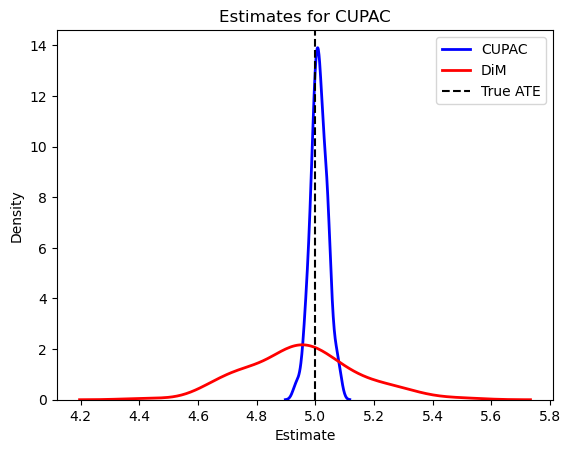

In [67]:
evaluation_cupac.plot(plot_what='estimates')

### MLRATE

In [68]:
mlrate_params_map = {
    'MLRATE': {
        'covariate_columns': ['pre_metric'],
        'K_splits': 2,
        'model': ElasticNet,
        'model_init_config': {},
        'model_fit_config': {
        }
    }
}

In [69]:
mlrate_evaluation = VREvaluation(MLRATE)
mlrate_evaluation = mlrate_evaluation.run(data=simple_synthetic_df,
                                            treatment_column='treatment',
                                            target_column='exp_metric',
                                            method_params_map=mlrate_params_map,
                                            verbose=True,
                                            n_bootstrap=100,
                                            true_ate=5)

Running MLRATE...


100%|██████████| 100/100 [00:02<00:00, 46.15it/s]


In [70]:
mlrate_evaluation.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,MLRATE,5.030026,"(4.98096892625206, 5.0704255947594765)",0.030026,"(-0.019031073747940552, 0.07042559475947617)",0.0,"(0.0, 0.0)",0.75,0.985396


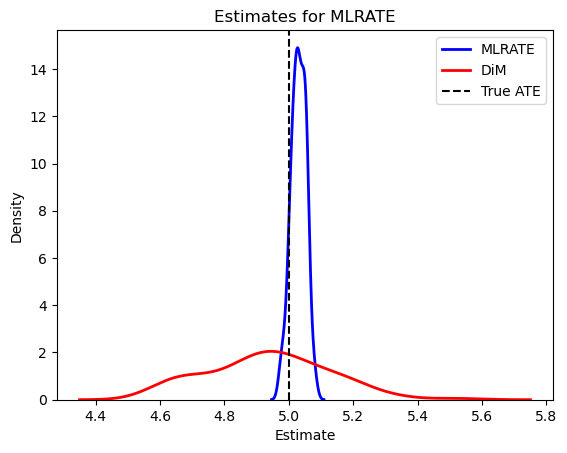

In [71]:
mlrate_evaluation.plot(plot_what='estimates')

In [72]:
# get training error
mlrate_evaluation.estimators[0]._diag['g_k_scores']

[0.9271525955588074, 0.9283210140501166]

In [73]:
err = mlrate_evaluation.estimators[0]._diag['g_pred'] - mlrate_evaluation.estimators[0]._diag['target']
mse = np.mean(err**2)

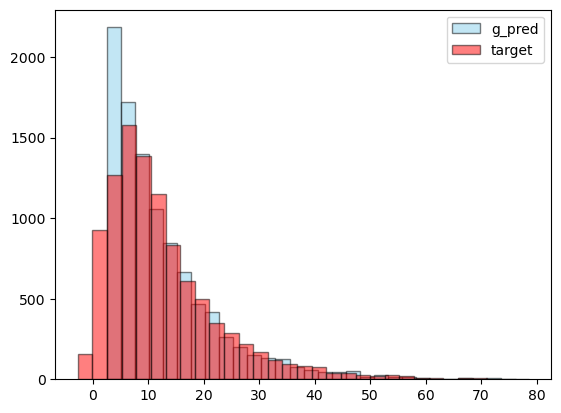

In [74]:
# plot histogram of g_pred and the target
plt.hist(mlrate_evaluation.estimators[0]._diag['g_pred'], bins=30, color='skyblue', edgecolor='black', alpha=0.5, label='g_pred')
plt.hist(mlrate_evaluation.estimators[0]._diag['target'], bins=30, color='red', edgecolor='black', alpha=0.5, label='target')
plt.legend()
plt.show()


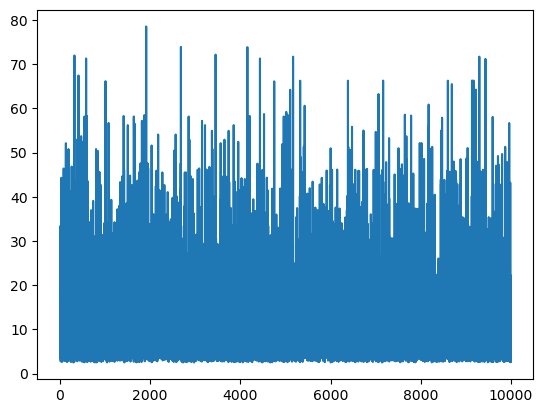

In [75]:
plt.plot(mlrate_evaluation.estimators[0]._diag['g_pred'])
plt.show()

In [76]:
mlrate_evaluation.bootstrap_samples[0]

array([6250, 2927, 6833, ..., 8314, 5172, 6767])

In [77]:
b_df = simple_synthetic_df.iloc[mlrate_evaluation.bootstrap_samples[0]].reset_index(drop=True)

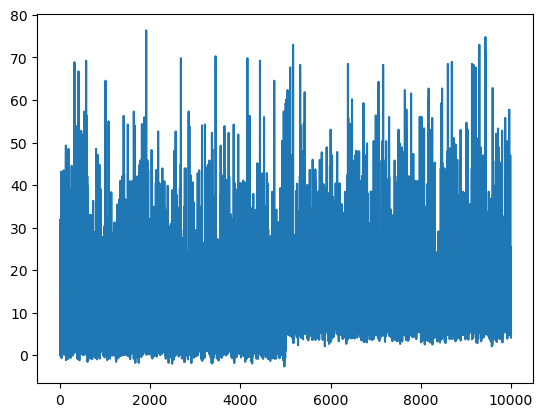

In [78]:
plt.plot(b_df['exp_metric'])
plt.show()

### Doubly Robust Estimator

In [79]:
dre_params_map = {
    'DoublyRobustEstimator': {
        'covariate_columns': ['pre_metric'],
        'model_regression': ExtraTreesRegressor
    }
}

In [80]:
dre_evaluation = VREvaluation(DoublyRobustEstimator)

In [81]:
dre_evaluation = dre_evaluation.run(data=simple_synthetic_df,
                                    treatment_column='treatment',
                                    target_column='exp_metric',
                                    method_params_map=dre_params_map,
                                    verbose=True,
                                    n_bootstrap=100,
                                    true_ate=5)


Running DoublyRobustEstimator...


 32%|███▏      | 32/100 [00:49<01:47,  1.59s/it]lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
100%|██████████| 100/100 [02:21<00:00,  1.41s/it]


In [82]:
dre_evaluation.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,DoublyRobustEstimator,5.029645,"(4.98399602779598, 5.076657782740988)",0.029645,"(-0.016003972204019834, 0.07665778274098743)",None,None,0.73,0.986113


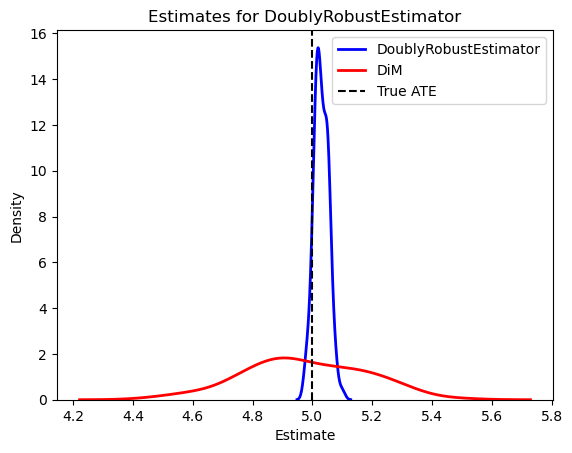

In [83]:
dre_evaluation.plot(plot_what='estimates')

### Alt MLRATE

In [84]:
altmlrate = AltMLRATE()

In [85]:
altmlrate = altmlrate.fit(data=simple_synthetic_df,
                          treatment_column='treatment',
                          target_column='exp_metric',
                          covariate_columns=['pre_metric'],
                          K_splits=2)     

In [90]:
altmlrate.regression_results.params['treatment']

5.060483229971322

In [91]:
altmlrate_params_map = {
    'AltMLRATE': {
        'covariate_columns': ['pre_metric'],
        'K_splits': 2,
        'model': LGBMRegressor,
        'model_init_config': {},
        'model_fit_config': {
        }
    }
}

In [92]:
altmlrate_evaluation = VREvaluation(AltMLRATE)

In [ ]:
altmlrate_evaluation = altmlrate_evaluation.run(data=simple_synthetic_df,
                                                treatment_column='treatment',
                                                target_column='exp_metric',
                                                method_params_map=altmlrate_params_map,
                                                verbose=True,
                                                n_bootstrap=100,
                                                true_ate=5)

In [ ]:
altmlrate_evaluation.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,AltMLRATE,4.357303,"(4.301210254298754, 4.422997829000688)",-0.642697,"(-0.6987897457012461, -0.5770021709993118)",0.0,"(0.0, 0.0)",0.0,0.971483


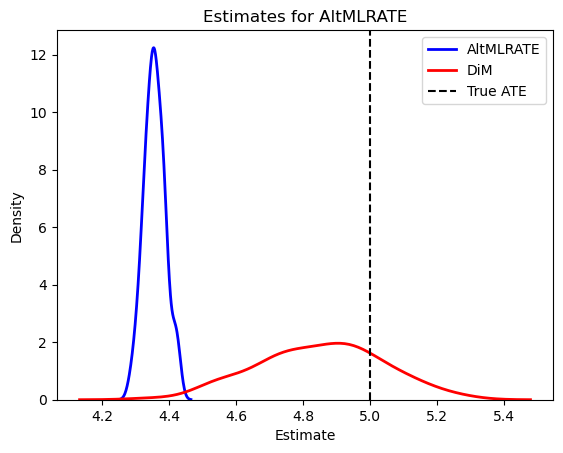

In [ ]:
altmlrate_evaluation.plot(plot_what='estimates')

In [ ]:
baseline_params_map = {
    'DifferenceInMeans': {
    }
}

In [ ]:
baseline_evaluation = VREvaluation(DifferenceInMeans)

In [ ]:
baseline_evaluation = baseline_evaluation.run(data=simple_synthetic_df,
                                                treatment_column='treatment',
                                                target_column='exp_metric',
                                                method_params_map=baseline_params_map,
                                                verbose=True,
                                                n_bootstrap=100,
                                                true_ate=5)

Running DifferenceInMeans...


100%|██████████| 100/100 [00:00<00:00, 209.51it/s]


In [94]:
baseline_evaluation.plot(plot_what='estimates')

NameError: name 'baseline_evaluation' is not defined

In [434]:
def dgp(n=2000, p=10, linear=True, constant=True):
    """DGP from https://github.com/muratunalphd/Blog-Posts/blob/main/variance-reduction-methods/MLRATE.ipynb"""
        
    Xmat = np.random.multivariate_normal(np.zeros(p), np.eye(p), size=n).astype('float32')

    T = np.random.binomial(1, 0.5, n).astype('int8')

    col_list = ['X' + str(x) for x in range(1,(p+1))]

    df = pd.DataFrame(Xmat, columns = col_list)
    
    # functional form of the covariates
    if linear:
        B = 225 + 50*df['X1'] + 5*df['X2'] + 20*(df['X3']-0.5) + 10*df['X4'] + 5*df['X5']
    else:
        B = 225 + 50*df['X1'] + 5*np.sin(np.pi*df['X1']*df['X2'] ) + 10*(df['X3']-0.5)**2 + 10*df['X4']**2 + 5*df['X5']**3
    
    # constant ate or non-constant
    tau = 1.8 if constant else 5*df['X1'] + 5*np.log(1 + np.exp(df['X2']))
    
    # Y = (B + tau*T + np.random.normal(0,25,n)).astype('float32')
    Y = (B + tau*T + np.random.normal(0,25,n)).astype('float32')
        
    df['T'] = T
    df['Y'] = Y    
    return df

In [435]:
nonlinear_synthetic_df = dgp(n=2000, p=10, linear=False, constant=True)
linear_synthetic_df = dgp(n=2000, p=10, linear=True, constant=True)

In [97]:
altmlrate_params_map = {
    'AltMLRATE': {
        'covariate_columns': list(linear_synthetic_df.columns[2:]),
        'K_splits': 2,
        'model': None,
        'model_init_config': {},
        'model_fit_config': {
        }
    }
}

In [98]:
altmlrate_evaluation = VREvaluation(AltMLRATE)

In [99]:
altmlrate_evaluation = altmlrate_evaluation.run(data=linear_synthetic_df,
                                                treatment_column='T',
                                                target_column='Y',
                                                method_params_map=altmlrate_params_map,
                                                verbose=True,
                                                n_bootstrap=100,
                                                true_ate=5)

Running AltMLRATE...


  0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:06<01:23,  1.12it/s]


KeyboardInterrupt: 

In [ ]:
altmlrate_evaluation.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,AltMLRATE,-0.020244,"(-0.19658534219356327, 0.16337737450783218)",-5.020244,"(-5.196585342193564, -4.836622625492168)",0.441552,"(0.017826643321663796, 0.9635948208446572)",0.0,0.998758


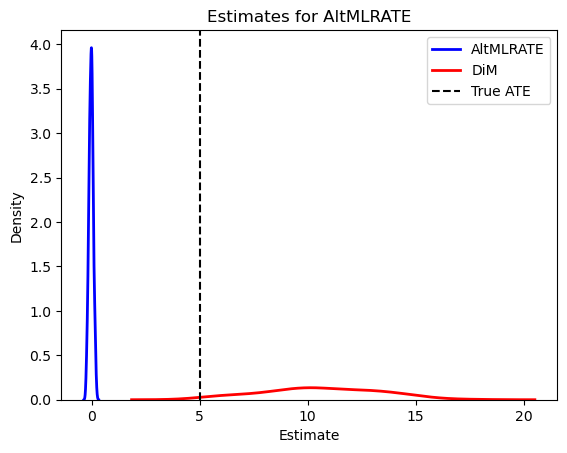

In [ ]:
altmlrate_evaluation.plot(plot_what='estimates')

In [ ]:
altmlrate_evaluation.bootstrap_samples

array([[1972,  443,  980, ..., 1936, 1112,   65],
       [1206, 1667, 1589, ...,  592,  207,  273],
       [1619,  223, 1014, ...,  277, 1660,  751],
       ...,
       [ 981, 1384, 1482, ...,  958,   87, 1543],
       [ 946,  190,  803, ..., 1428, 1908,  637],
       [1600,  110, 1453, ...,  458,   12,  792]])

In [ ]:
linear_synthetic_df.columns

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'T', 'Y'], dtype='object')

## More complicated synthetic data with linear effect

In [474]:
linear_synthetic_df
pre_exp_linear_synthetic_df = dgp(n=2000, p=10, linear=True, constant=True)
pre_exp_linear_synthetic_df = pre_exp_linear_synthetic_df.loc[pre_exp_linear_synthetic_df['T'] == 0]

### Eval All

In [475]:
method_params_map4 = {

    'DifferenceInMeans': {
    },
    
    'CUPED': {
        'covariate_column': linear_synthetic_df.columns.to_list()[0]
    },

    'MultivariateCUPED': {
        'covariate_columns': linear_synthetic_df.columns.to_list()[0:10]
    },

    'MultivariateRegression': {
        'covariate_columns': linear_synthetic_df.columns.to_list()[0:10]
    },

    'MultivariateRegressionAdjusted': {
        'covariate_columns': linear_synthetic_df.columns.to_list()[0:10]
    },

    'CUPAC': {
        'pre_experiment_data': pre_exp_linear_synthetic_df,
        'covariate_columns': pre_exp_linear_synthetic_df.columns.to_list()[0:10],
        'model': LGBMRegressor,
        'model_init_config': {},
        'model_fit_config': {}
    },

    'MLRATE': {
        'K_splits': 2,
        'covariate_columns': linear_synthetic_df.columns.to_list()[0:10],
        'model': ElasticNet,
        'model_init_config': {},
        'model_fit_config': {}
    },

    'DoublyRobustEstimator': {
        'covariate_columns': linear_synthetic_df.columns.to_list()[0:10],
        'model_regression': LGBMRegressor
        
    }

}

In [476]:
evaluator_all4 = VREvaluationAll([
                                  DifferenceInMeans, 
                                  CUPED, 
                                  MultivariateCUPED,
                                  MultivariateRegression, 
                                  MultivariateRegressionAdjusted, 
                                  CUPAC, 
                                  MLRATE
                                  , 
                                  DoublyRobustEstimator
                                  ])

In [477]:
evaluator_all4.run_all(data=linear_synthetic_df,
                       target_column='Y',
                       treatment_column='T',
                       method_params_map=method_params_map4,
                       verbose=True,
                       n_bootstrap=100,
                       true_ate=diff_in_means(linear_synthetic_df, 'T', 'Y'))
                       

Running DifferenceInMeans...


100%|██████████| 100/100 [00:01<00:00, 87.53it/s]


Running CUPED...


100%|██████████| 100/100 [00:02<00:00, 45.52it/s]


Running MultivariateCUPED...


100%|██████████| 100/100 [00:01<00:00, 51.26it/s]


Running MultivariateRegression...


100%|██████████| 100/100 [00:02<00:00, 41.01it/s]


Running MultivariateRegressionAdjusted...


100%|██████████| 100/100 [00:03<00:00, 28.31it/s]


Running CUPAC...


100%|██████████| 100/100 [00:10<00:00,  9.31it/s]


Running MLRATE...


100%|██████████| 100/100 [00:04<00:00, 23.01it/s]


Running DoublyRobustEstimator...


100%|██████████| 100/100 [00:43<00:00,  2.29it/s]

Done!


In [478]:
evaluator_all4.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,DifferenceInMeans,-0.325232,"(-4.950525992206066, 5.132097788295246)",-0.747458,"(-5.372751944354503, 4.709871836146808)",0.499702,"(0.036042689503826615, 0.9805917415525136)",0.95,0.000000
1,CUPED,1.474512,"(-1.174317948738258, 4.09348326085292)",1.052286,"(-1.5965439008866955, 3.6712573087044826)",0.358689,"(0.005677607364581908, 0.9530019982575476)",0.90,0.707522
2,MultivariateCUPED,0.587970,"(-1.0922903621868978, 2.7110522032680366)",0.165744,"(-1.5145163143353353, 2.288826251119599)",0.514683,"(0.011536295948838413, 0.97783316497922)",0.95,0.855482
3,MultivariateRegression,0.595568,"(-1.103445962164689, 2.7531029110190124)",0.173342,"(-1.5256719143131265, 2.330876958870575)",0.513661,"(0.011133877769523742, 0.9777532701077386)",0.95,0.851847
4,MultivariateRegressionAdjusted,0.593845,"(-1.1011645719758876, 2.7482394604386466)",0.171619,"(-1.523390524124325, 2.326013508290209)",0.511883,"(0.011127250606088641, 0.9695833554237026)",0.95,0.851424
5,CUPAC,0.714408,"(-1.1789891393992034, 2.678220172894525)",0.292182,"(-1.6012150915476409, 2.2559942207460875)",0.497192,"(0.018507810107225093, 0.9698693715113733)",0.96,0.811974
6,MLRATE,0.617641,"(-1.103244775653033, 2.8254341364055624)",0.195415,"(-1.5254707278014705, 2.403208184257125)",0.511968,"(0.010891849667285482, 0.9865153860955296)",0.95,0.854842
7,DoublyRobustEstimator,0.575924,"(-0.9266775297488922, 2.109035509000214)",0.153698,"(-1.3489034818973298, 1.6868095568517767)",None,None,0.99,0.892671


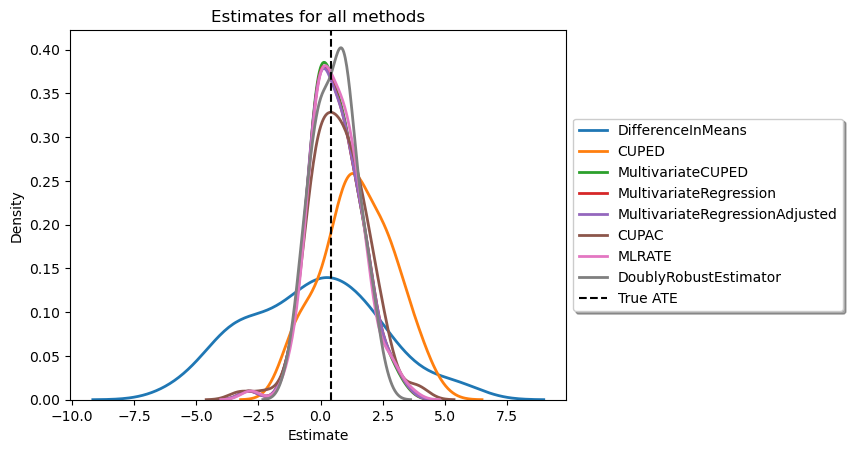

<Axes: title={'center': 'Estimates for all methods'}, xlabel='Estimate', ylabel='Density'>

In [479]:
evaluator_all4.plot(plot_what='estimates')

In [106]:
evaluator_all4.evaluations['MLRATE'].estimators[10]._diag['g_k_scores']

[0.714226933877433, 0.742851848396159]

In [23]:
Y_0_mean = linear_synthetic_df.loc[linear_synthetic_df['T']==0]['Y'].mean()
Y_1_mean = linear_synthetic_df.loc[linear_synthetic_df['T']==1]['Y'].mean()

Y_1_mean - Y_0_mean

4.192688

## More complicated synthetic data with nonlinear effect

In [480]:
nonlinear_synthetic_df
pre_exp_nonlinear_synthetic_df = dgp(n=2000, p=10, linear=False, constant=True)
pre_exp_nonlinear_synthetic_df = pre_exp_nonlinear_synthetic_df.loc[pre_exp_nonlinear_synthetic_df['T'] == 0]

### Eval All

In [481]:
method_params_map5 = {

    'DifferenceInMeans': {
    },
    
    'CUPED': {
        'covariate_column': nonlinear_synthetic_df.columns.to_list()[4]
    },

    'MultivariateCUPED': {
        'covariate_columns': nonlinear_synthetic_df.columns.to_list()[4:10] 
    },

    'MultivariateRegression': {
        'covariate_columns': nonlinear_synthetic_df.columns.to_list()[4:10]
    },

    'MultivariateRegressionAdjusted': {
        'covariate_columns': nonlinear_synthetic_df.columns.to_list()[4:10]
    },

    'CUPAC': {
        'pre_experiment_data': pre_exp_nonlinear_synthetic_df,
        'covariate_columns': pre_exp_nonlinear_synthetic_df.columns.to_list()[4:10],
        'model': LGBMRegressor,
        'model_init_config': {},
        'model_fit_config': {}
    },

    'MLRATE': {
        'K_splits': 2,
        'covariate_columns': nonlinear_synthetic_df.columns.to_list()[4:10],
        'model': LGBMRegressor,
        'model_init_config': {},
        'model_fit_config': {}
    },

    'DoublyRobustEstimator': {
        'covariate_columns': nonlinear_synthetic_df.columns.to_list()[4:10],
        'model_regression': LGBMRegressor

    }

}

In [482]:
evaluator_all5 = VREvaluationAll([DifferenceInMeans, 
                            CUPED, 
                            MultivariateCUPED,
                            MultivariateRegression, 
                            MultivariateRegressionAdjusted, 
                            CUPAC, 
                            MLRATE, 
                            DoublyRobustEstimator])

In [483]:
evaluator_all5.run_all(data=nonlinear_synthetic_df,
                       target_column='Y',
                       treatment_column='T',
                       method_params_map=method_params_map5,
                       verbose=True,
                       n_bootstrap=100,
                       true_ate=diff_in_means(nonlinear_synthetic_df, 'T', 'Y'))
                       

Running DifferenceInMeans...


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 211.20it/s]


Running CUPED...


100%|██████████| 100/100 [00:01<00:00, 92.59it/s]


Running MultivariateCUPED...


100%|██████████| 100/100 [00:01<00:00, 82.21it/s]


Running MultivariateRegression...


100%|██████████| 100/100 [00:01<00:00, 92.22it/s]


Running MultivariateRegressionAdjusted...


100%|██████████| 100/100 [00:01<00:00, 64.40it/s]


Running CUPAC...


100%|██████████| 100/100 [00:05<00:00, 17.25it/s]


Running MLRATE...


100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


Running DoublyRobustEstimator...


100%|██████████| 100/100 [00:30<00:00,  3.28it/s]

Done!


In [484]:
evaluator_all5.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,DifferenceInMeans,7.923835,"(2.8831418215542617, 13.643312775252598)",-0.481133,"(-5.521826440164488, 5.238344513533847)",0.049249,"(4.0791255697865145e-06, 0.32038615966417267)",0.97,0.000000
1,CUPED,8.435493,"(3.842087228052417, 13.457058218058892)",0.030524,"(-4.562881033666333, 5.052089956340142)",0.030863,"(1.258565425263709e-06, 0.16720824573163862)",0.97,0.152305
2,MultivariateCUPED,8.302025,"(3.820694191403153, 13.2988857304806)",-0.102943,"(-4.584274070315597, 4.893917468761851)",0.032414,"(1.598947519262008e-06, 0.1660420016977448)",0.97,0.166613
3,MultivariateRegression,8.341994,"(3.834579027775348, 13.354809008546995)",-0.062974,"(-4.570389233943402, 4.949840746828246)",0.032325,"(1.6008359175921844e-06, 0.16599041464471853)",0.97,0.160392
4,MultivariateRegressionAdjusted,8.338841,"(3.82143787229591, 13.370251825244527)",-0.066127,"(-4.58353038942284, 4.965283563525776)",0.032016,"(1.480683483212223e-06, 0.16534719894120986)",0.97,0.158766
5,CUPAC,8.594289,"(3.50149920812774, 14.300613762644081)",0.189320,"(-4.90346905359101, 5.8956455009253315)",0.034201,"(9.028008203089097e-07, 0.22046502142551544)",0.94,0.017062
6,MLRATE,7.012452,"(3.6714145495192256, 11.413977925250657)",-1.392517,"(-4.733553712199524, 3.009009663531908)",0.022449,"(1.8057058774703118e-06, 0.1361102847236549)",0.97,0.518235
7,DoublyRobustEstimator,8.686129,"(3.9821434231351405, 13.510932661060467)",0.281160,"(-4.422824838583609, 5.105964399341717)",None,None,0.94,0.284716


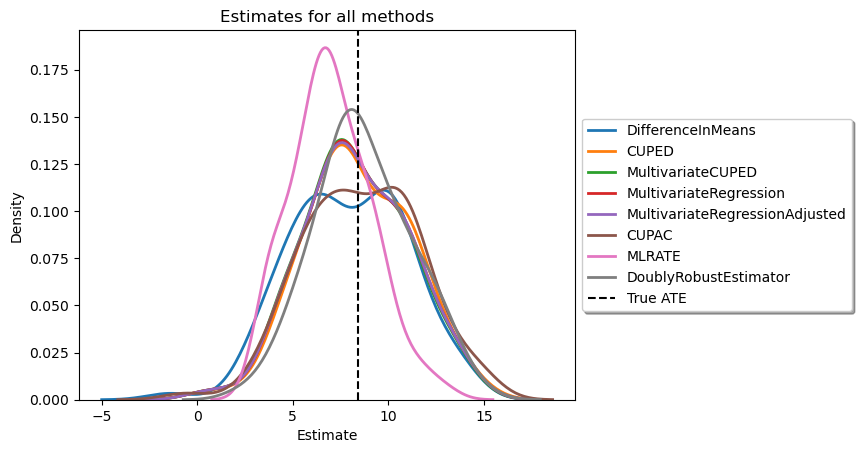

<Axes: title={'center': 'Estimates for all methods'}, xlabel='Estimate', ylabel='Density'>

In [485]:
evaluator_all5.plot(plot_what='estimates')

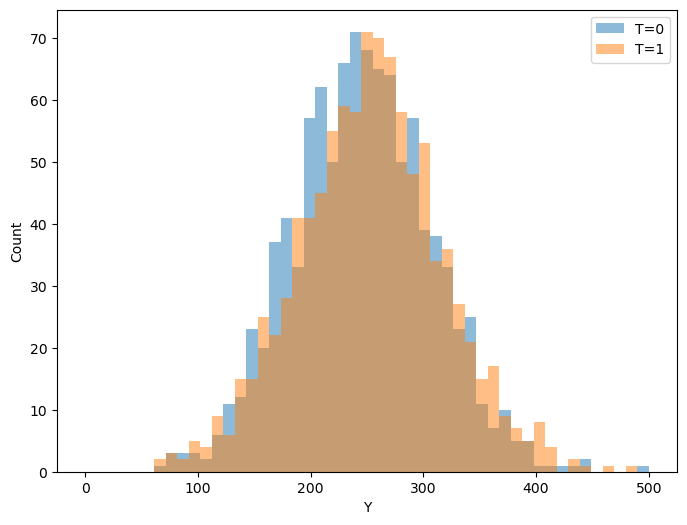

In [21]:
Y_0 = nonlinear_synthetic_df.loc[nonlinear_synthetic_df['T'] == 0]['Y']
Y_1 = nonlinear_synthetic_df.loc[nonlinear_synthetic_df['T'] == 1]['Y']

bins = np.linspace(0,500, 50)

# plot histogram
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(Y_0, bins=bins, alpha=0.5, label='T=0')
ax.hist(Y_1, bins=bins, alpha=0.5, label='T=1')
ax.set_xlabel('Y')
ax.set_ylabel('Count')
ax.legend()
plt.show()


In [22]:
nonlinear_synthetic_df.loc[nonlinear_synthetic_df['T'] == 1, 'Y'].mean() - nonlinear_synthetic_df.loc[nonlinear_synthetic_df['T'] == 0, 'Y'].mean()

7.191925

### MLRATE

In [114]:
mlrate_params_map = {
    
    'DifferenceInMeans':{

    },

    'MultivariateRegressionAdjusted': {
        'covariate_columns': nonlinear_synthetic_df.columns.to_list()[5:10]
    },

    'MLRATE': {
        'K_splits': 2,
        'covariate_columns': nonlinear_synthetic_df.columns.to_list()[5:10],
        'model': LGBMRegressor,
        'model_init_config': {
            # 'reg_lambda':0.005
            # 'max_depth':100
        },
        'model_fit_config': {
            # 'task': 'regression',
            # 'metric': 'mse',
            # 'time_budget': 60,
        }
    },
}

In [115]:
evaluation_mlrate = VREvaluationAll([DifferenceInMeans, MultivariateRegressionAdjusted, MLRATE])
evaluation_mlrate = evaluation_mlrate.run_all(data=nonlinear_synthetic_df,
                       target_column='Y',
                       treatment_column='T',
                       method_params_map=mlrate_params_map,
                       verbose=True,
                       n_bootstrap=100,
                       true_ate=-5)

Running DifferenceInMeans...


100%|██████████| 100/100 [00:00<00:00, 177.40it/s]


Running MultivariateRegressionAdjusted...


100%|██████████| 100/100 [00:01<00:00, 55.08it/s]


Running MLRATE...


100%|██████████| 100/100 [00:14<00:00,  7.05it/s]

Done!


In [116]:
evaluation_mlrate.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,DifferenceInMeans,5.645256,"(0.6818799011297026, 10.669412524655755)",10.645256,"(5.681879901129703, 15.669412524655755)",0.139791,"(0.00010696931914237027, 0.8058377592931522)",0.02,0.000000
1,MultivariateRegressionAdjusted,5.647684,"(0.5395566181523943, 10.77077623207162)",10.647684,"(5.539556618152394, 15.77077623207162)",0.138083,"(6.827758568282293e-05, 0.8292854408335204)",0.02,-0.006959
2,MLRATE,4.211554,"(-0.08446962080501697, 8.58816369759362)",9.211554,"(4.915530379194983, 13.58816369759362)",0.194858,"(0.0004588462672292074, 0.9030767907223967)",0.03,0.295368


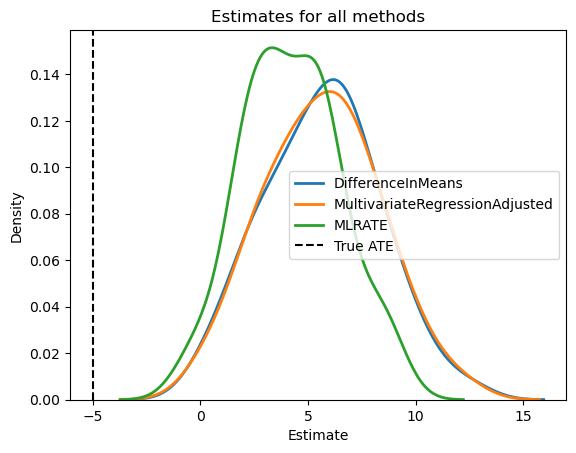

In [117]:
evaluation_mlrate.plot(plot_what='estimates')

In [118]:
evaluation_mlrate.evaluations['MLRATE'].estimators[10]._diag['g_k_scores']

[0.8894273498215226, 0.8694175281937611]

## MLRATE paper data

In [519]:
def b(X_i):

    return 10 * np.sin(np.pi * X_i[:, 0] * X_i[:, 1]) \
             + 20 * (X_i[:, 2] - 0.5)**2 \
             +10 * X_i[:, 3] + 5 * X_i[:, 4]

def tau(X_i):

    return X_i[:, 0] + np.log(1 + np.exp(X_i[:, 1]))

def mlrate_synthetic(N=10000, p=0.5):

    X = np.random.multivariate_normal(np.zeros(100), np.identity(100), N)
    T = np.random.binomial(1, p, N)

    Y = b(X) + T * tau(X) + np.random.normal(0, 25, N)

    X_df = pd.DataFrame(X).add_prefix("X_")

    df_columns = {"Y": Y, "T": T}

    df = pd.DataFrame(df_columns)
    df = pd.merge(df, X_df, left_index=True, right_index=True)

    return df

In [520]:
mlrate_synthetic_df = mlrate_synthetic(N=5000)

In [521]:
mlrate_synthetic_df.columns
mlrate_covariates = mlrate_synthetic_df.columns.tolist()[2:]

In [522]:
method_params_map7 = {

    'DifferenceInMeans': {
    },
    
    'CUPED': {
        'covariate_column': mlrate_covariates[0]
    },

    'MultivariateCUPED': {
        'covariate_columns': mlrate_covariates
    },

    'MultivariateRegression': {
        'covariate_columns': mlrate_covariates
    },

    'MultivariateRegressionAdjusted': {
        'covariate_columns': mlrate_covariates
    },


    # 'CUPAC': {
    #     'pre_experiment_data': 'ml_synthetic_df',
    #     'covariate_columns': list(ml_synthetic_df.columns[2:10]),
    #     'model': HistGradientBoostingRegressor,
    #     'model_init_config': {},
    #     'model_fit_config': {}
    # },

    'MLRATE': {
        'K_splits': 2,
        'covariate_columns': mlrate_covariates,
        'model': LGBMRegressor,
        'model_init_config': {},
        'model_fit_config': {}
    },

    'DoublyRobustEstimator': {
        'covariate_columns': mlrate_covariates,
        'model_regression': LGBMRegressor,
        'model_propensity': 'auto',
    }

}

In [523]:
evaluator_all7 = VREvaluationAll([DifferenceInMeans, 
                                 MultivariateRegression,
                                 MultivariateRegressionAdjusted,
                                 CUPED, 
                                 MultivariateCUPED,
                                 MLRATE, 
                                 DoublyRobustEstimator])

evaluator_all7.run_all(data=mlrate_synthetic_df,
                       treatment_column='T',
                       target_column='Y',
                       method_params_map=method_params_map7,
                       verbose=True,
                       n_bootstrap=100,
                       true_ate=diff_in_means(mlrate_synthetic_df, 'T', 'Y'))

Running DifferenceInMeans...


100%|██████████| 100/100 [00:00<00:00, 114.13it/s]


Running MultivariateRegression...


100%|██████████| 100/100 [00:07<00:00, 13.06it/s]


Running MultivariateRegressionAdjusted...


100%|██████████| 100/100 [00:22<00:00,  4.46it/s]


Running CUPED...


100%|██████████| 100/100 [00:01<00:00, 63.52it/s]


Running MultivariateCUPED...


100%|██████████| 100/100 [00:02<00:00, 41.06it/s]


Running MLRATE...


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


Running DoublyRobustEstimator...


100%|██████████| 100/100 [02:06<00:00,  1.26s/it]

Done!


In [524]:
evaluator_all7.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,DifferenceInMeans,1.567278,"(-0.6235290262218127, 3.7951222744713107)",-0.140477,"(-2.331283604548907, 2.0873676961442165)",0.308548,"(0.0032680935168928585, 0.964645564163002)",0.96,0.000000
1,MultivariateRegression,0.709524,"(-0.9875280598589451, 2.5872380100150116)",-0.998231,"(-2.6952826381860393, 0.8794834316879173)",0.446489,"(0.019549270666926705, 0.9624622896951718)",0.86,0.270720
2,MultivariateRegressionAdjusted,0.705835,"(-1.0284380830597353, 2.5345573841939784)",-1.001920,"(-2.7361926613868293, 0.8268028058668843)",0.44382,"(0.020383462497823104, 0.9605047964745947)",0.85,0.277381
3,CUPED,1.539690,"(-0.6228882318863739, 3.74680658649504)",-0.168065,"(-2.330642810213468, 2.0390520081679457)",0.31325,"(0.003536525797879979, 0.9525237332415751)",0.96,0.000423
4,MultivariateCUPED,0.683786,"(-0.9457652333118037, 2.4844338778531294)",-1.023969,"(-2.653519811638898, 0.7766792995260352)",0.449312,"(0.020808422437912238, 0.9628225409623974)",0.85,0.323834
5,MLRATE,0.506167,"(-0.5760960486687947, 1.334444426382392)",-1.201588,"(-2.283850626995889, -0.37331015194470213)",0.433105,"(0.03536251594430303, 0.9450239000931449)",0.52,0.790940
6,DoublyRobustEstimator,0.580495,"(-0.3602687774939656, 1.7392033365307156)",-1.127260,"(-2.06802335582106, 0.03144875820362133)",None,None,0.63,0.762400


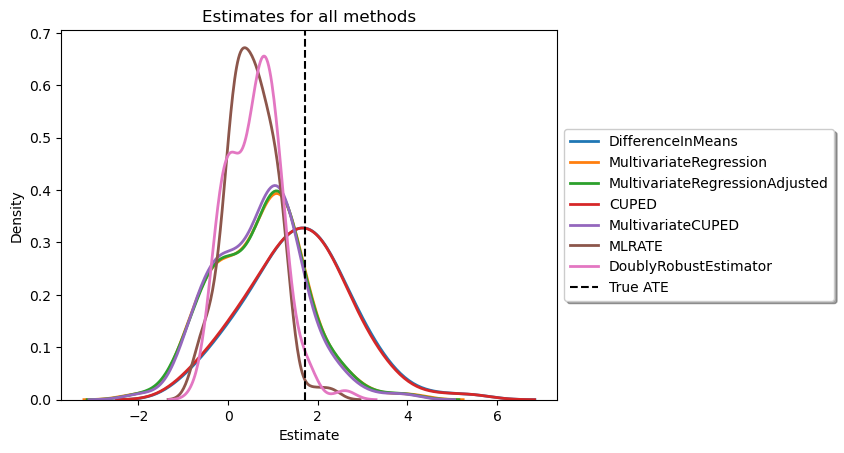

<Axes: title={'center': 'Estimates for all methods'}, xlabel='Estimate', ylabel='Density'>

In [525]:
evaluator_all7.plot(plot_what='estimates')